In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from dgl import DGLGraph, batch as dgl_batch
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors as rdDesc
#from utils import one_of_k_encoding_unk, one_of_k_encoding
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import ast
import random
import pandas as pd
from rdkit import Chem
# Global constants (adjust as needed)
NUM_ATOMS = 100       # Maximum number of atoms per molecule
BOND_DIM = 5          # Four bond types + 1 "non-bond" channel

# Optional: Determine ATOM_DIM automatically from one sample.
# (Alternatively, set ATOM_DIM manually if you know its value.)

#print("ATOM_DIM:", ATOM_DIM)  # For debugging

# -----------------------------------------------
# --- Your Featurization Functions (unchanged) ---
# -----------------------------------------------


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]

    return list(map(lambda s: x == s, allowable_set))


def get_len_matrix(len_list):
    len_list = np.array(len_list)
    max_nodes = np.sum(len_list)
    curr_sum = 0
    len_matrix = []
    for l in len_list:
        curr = np.zeros(max_nodes)
        curr[curr_sum:curr_sum + l] = 1
        len_matrix.append(curr)
        curr_sum += l
    return np.array(len_matrix)


def get_atom_features(atom, stereo, features, explicit_H=False):
    """
    Computes atom-level features for an RDKit atom.
    """
    possible_atoms = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'Si']
    atom_features = one_of_k_encoding_unk(atom.GetSymbol(), possible_atoms)
    atom_features += one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1])
    atom_features += one_of_k_encoding_unk(atom.GetNumRadicalElectrons(), [0, 1])
    atom_features += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6])
    atom_features += one_of_k_encoding_unk(atom.GetFormalCharge(), [-1, 0, 1])
    atom_features += one_of_k_encoding_unk(atom.GetHybridization(), [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D])
    atom_features += [int(i) for i in list("{0:06b}".format(features))]

    if not explicit_H:
        atom_features += one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])

    try:
        atom_features += one_of_k_encoding_unk(stereo, ['R', 'S'])
        atom_features += [atom.HasProp('_ChiralityPossible')]
    except Exception as e:
        atom_features += [False, False] + [atom.HasProp('_ChiralityPossible')]

    return np.array(atom_features)

def get_bond_features(bond):
    """
    Computes bond-level features for an RDKit bond.
    """
    bond_type = bond.GetBondType()
    bond_feats = [
        bond_type == Chem.rdchem.BondType.SINGLE,
        bond_type == Chem.rdchem.BondType.DOUBLE,
        bond_type == Chem.rdchem.BondType.TRIPLE,
        bond_type == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    bond_feats += one_of_k_encoding_unk(str(bond.GetStereo()),
                                          ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)

def get_graph_from_smile(molecule_smile):
    """
    Constructs a DGL graph from a SMILES string.
    Nodes get features stored in ndata['x'] and edges get features in edata['w'].
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    G = DGLGraph().to(device)
    molecule = Chem.MolFromSmiles(molecule_smile)
    features = rdDesc.GetFeatureInvariants(molecule)

    stereo = Chem.FindMolChiralCenters(molecule)
    chiral_centers = [0] * molecule.GetNumAtoms()
    for i in stereo:
        chiral_centers[i[0]] = i[1]

    num_atoms = molecule.GetNumAtoms()
    G.add_nodes(num_atoms)
    node_features = []
    src_nodes = []
    dst_nodes = []
    edge_features = []

    for i in range(num_atoms):
        atom_i = molecule.GetAtomWithIdx(i)
        atom_i_features = get_atom_features(atom_i, chiral_centers[i], features[i])
        node_features.append(atom_i_features)

        for j in range(num_atoms):
            bond_ij = molecule.GetBondBetweenAtoms(i, j)
            if bond_ij is not None:
                src_nodes.append(i)
                dst_nodes.append(j)
                bond_features_ij = get_bond_features(bond_ij)
                edge_features.append(bond_features_ij)

    if len(src_nodes) > 0:
        G.add_edges(src_nodes, dst_nodes)
        G.edata['w'] = torch.Tensor(edge_features).to(device)
    else:
        G.edata['w'] = torch.empty((0, 0)).to(device)

    G.ndata['x'] = torch.Tensor(node_features).to(device)
    return G

# -------------------------------------------------
# --- Modified Dataset for the VAE Model Inputs ---
# -------------------------------------------------
class MoleculeGraphDataset(Dataset):
    """
    PyTorch Dataset that converts SMILES strings into a fixed-size
    (adjacency, features) pair compatible with the VAE model.

    Each sample returns:
        ((adjacency, features), target)   if target_col is provided,
        or ((adjacency, features))         otherwise.

    The conversion procedure:
      - Build a DGL graph from the SMILES.
      - Create a feature tensor of shape (NUM_ATOMS, ATOM_DIM):
           * Fill in the first n rows with the node features.
           * Pad the rest with a "non-atom" indicator (1 in the last column).
      - Create an adjacency tensor of shape (BOND_DIM, NUM_ATOMS, NUM_ATOMS):
           * For each edge, determine the bond type from the edge features
             (first four entries indicate SINGLE, DOUBLE, TRIPLE, AROMATIC).
           * For each pair (i,j) with no bond, set channel index -1 (the last channel) to 1.
    """
    def __init__(self, dataframe, smiles_col='smiles', target_col=None, num_atoms=NUM_ATOMS):
        self.df = dataframe.reset_index(drop=True)
        self.smiles_col = smiles_col
        self.target_col = target_col
        self.num_atoms = num_atoms

        # Set ATOM_DIM based on a sample SMILES string.
        sample_smile = self.df.loc[0, self.smiles_col]
        g = get_graph_from_smile(sample_smile)
        # Assume node features have shape (n_nodes, d); we need d.
        self.atom_dim = g.ndata['x'].shape[1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        smile = self.df.loc[idx, self.smiles_col]
        g = get_graph_from_smile(smile)
        n_nodes = g.number_of_nodes()
        # Get node features (move to CPU for stacking)
        node_features = g.ndata['x'].cpu()
        # Initialize fixed-size feature tensor: (NUM_ATOMS, ATOM_DIM)
        feat = torch.zeros(self.num_atoms, self.atom_dim, dtype=torch.float32)
        feat[:n_nodes, :] = node_features
        # For positions with no atom, set the "non-atom" indicator:
        if n_nodes < self.num_atoms:
            feat[n_nodes:, -1] = 1.0

        # Initialize adjacency tensor: (BOND_DIM, NUM_ATOMS, NUM_ATOMS)
        adj = torch.zeros(BOND_DIM, self.num_atoms, self.num_atoms, dtype=torch.float32)
        # Get edges and their features
        src, dst = g.edges()
        src = src.cpu().numpy()
        dst = dst.cpu().numpy()
        edge_features = g.edata['w'].cpu().numpy()

        # For each edge, determine bond type and fill the adjacency tensor.
        # We assume that the first 4 entries of bond_features indicate:
        #   [SINGLE, DOUBLE, TRIPLE, AROMATIC]
        for i in range(len(src)):
            u = src[i]
            v = dst[i]
            bond_feat = edge_features[i]
            if bond_feat[0]:
                bond_type = 0
            elif bond_feat[1]:
                bond_type = 1
            elif bond_feat[2]:
                bond_type = 2
            elif bond_feat[3]:
                bond_type = 3
            else:
                continue  # skip if none of the expected types
            if u < self.num_atoms and v < self.num_atoms:
                adj[bond_type, u, v] = 1
                adj[bond_type, v, u] = 1  # ensure symmetry

        # For any atom pair (i,j) with no bond, mark the non-bond channel.
        non_bond_mask = torch.sum(adj, dim=0) == 0
        adj[-1][non_bond_mask] = 1.0

        if self.target_col is not None:
            target = self.df.loc[idx, self.target_col]
            target = torch.tensor(target, dtype=torch.float32)
            return (adj, feat), target
        else:
            return (adj, feat)

# -------------------------------
# --- Collate Function for Loader ---
# -------------------------------
def collate_fn(batch):
    """
    Combines individual samples into a batch.
    Expects each sample to be ((adjacency, features), target) or just ((adjacency, features)).
    Returns:
        ((batch_adj, batch_feat), batch_targets)  if targets are provided,
        else ((batch_adj, batch_feat)).
    """
    adjs, feats, targets = [], [], []
    for sample in batch:
        # sample is either ((adj, feat), target) or (adj, feat)
        if isinstance(sample, (list, tuple)) and len(sample) == 2 and isinstance(sample[1], torch.Tensor):
            (adj, feat), target = sample
            adjs.append(adj)
            feats.append(feat)
            targets.append(target)
        else:
            adj, feat = sample
            adjs.append(adj)
            feats.append(feat)
    batch_adj = torch.stack(adjs, dim=0)  # (B, BOND_DIM, NUM_ATOMS, NUM_ATOMS)
    batch_feat = torch.stack(feats, dim=0) # (B, NUM_ATOMS, ATOM_DIM)
    if targets:
        batch_targets = torch.stack(targets, dim=0)
        return (batch_adj, batch_feat), batch_targets
    else:
        return (batch_adj, batch_feat)

def get_atom_dim(sample_smile):
    mol = Chem.MolFromSmiles(sample_smile)
    features = rdDesc.GetFeatureInvariants(mol)
    stereo = Chem.FindMolChiralCenters(mol)
    chiral_centers = [0] * mol.GetNumAtoms()
    for i in stereo:
        chiral_centers[i[0]] = i[1]
    # Build a temporary DGL graph to get the feature vector of the first atom.
    G = DGLGraph()
    G.add_nodes(mol.GetNumAtoms())
    # Here we call your provided function:
    node_features = []
    for i in range(mol.GetNumAtoms()):

        atom_i = mol.GetAtomWithIdx(i)
        feat = get_atom_features(atom_i, chiral_centers[i], features[i])
        node_features.append(feat)
    dummy = np.array(node_features[0])
    return len(dummy)


In [17]:
# Compute ATOM_DIM from a sample SMILES string (or set manually)
_SAMPLE_SMILE = "CCCCCC"
ATOM_DIM = get_atom_dim(_SAMPLE_SMILE)
ATOM_DIM

42

In [74]:
get_graph_from_smile(_SAMPLE_SMILE)

Graph(num_nodes=6, num_edges=10,
      ndata_schemes={'x': Scheme(shape=(42,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(10,), dtype=torch.float32)})

In [4]:
from torch import nn
from torch.functional import F

In [8]:

# =============================================================================
# Model Components
# =============================================================================

# --- Relational Graph Convolution Layer ---
class RelationalGraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=False, activation=F.relu):
        """
        in_features: input feature dimension (ATOM_DIM)
        out_features: output feature dimension
        """
        super(RelationalGraphConvLayer, self).__init__()
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation
        # One weight matrix per bond type: shape (BOND_DIM, in_features, out_features)
        self.weight = nn.Parameter(torch.Tensor(BOND_DIM, in_features, out_features))
        if use_bias:
            self.bias = nn.Parameter(torch.Tensor(BOND_DIM, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, adjacency, features):
        # adjacency: (B, BOND_DIM, NUM_ATOMS, NUM_ATOMS)
        # features:  (B, NUM_ATOMS, in_features)
        batch_size = features.size(0)
        # Expand features: (B, 1, NUM_ATOMS, in_features)
        features_expanded = features.unsqueeze(1)
        # Aggregate neighbor features: (B, BOND_DIM, NUM_ATOMS, in_features)
        agg = torch.matmul(adjacency, features_expanded)
        # Apply bond-type–specific linear transformation using einsum
        out = torch.einsum('b r i d, r d o -> b r i o', agg, self.weight)
        if self.bias is not None:
            out = out + self.bias  # broadcasting over the NUM_ATOMS dimension
        # Sum over the bond-type dimension → (B, NUM_ATOMS, out_features)
        out = torch.sum(out, dim=1)
        return self.activation(out)

# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, gconv_units, dense_units, latent_dim, feature_shape, dropout_rate=0.0):
        """
        gconv_units: list of output dims for graph conv layers
        dense_units: list of hidden dims for dense layers after pooling
        feature_shape: tuple (NUM_ATOMS, ATOM_DIM)
        """
        super(Encoder, self).__init__()
        in_features = feature_shape[1]  # ATOM_DIM
        self.gconv_layers = nn.ModuleList()
        for units in gconv_units:
            self.gconv_layers.append(RelationalGraphConvLayer(in_features, units))
            in_features = units  # update for next layer

        # Global average pooling over atoms
        self.global_pool = lambda x: torch.mean(x, dim=1)

        # Build dense layers
        dense_layers = []
        input_dim = in_features
        for units in dense_units:
            dense_layers.append(nn.Linear(input_dim, units))
            dense_layers.append(nn.ReLU())
            if dropout_rate > 0.0:
                dense_layers.append(nn.Dropout(dropout_rate))
            input_dim = units
        self.dense = nn.Sequential(*dense_layers)
        self.z_mean_layer = nn.Linear(input_dim, latent_dim)
        self.log_var_layer = nn.Linear(input_dim, latent_dim)

    def forward(self, adjacency, features):
        # Pass through graph conv layers
        x = features
        for layer in self.gconv_layers:
            x = layer(adjacency, x)
        # Global pooling (averaging over atoms)
        x = self.global_pool(x)
        # Dense layers
        x = self.dense(x)
        z_mean = self.z_mean_layer(x)
        log_var = self.log_var_layer(x)
        return z_mean, log_var

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
        """
        dense_units: list of hidden dims for dense layers
        adjacency_shape: tuple (BOND_DIM, NUM_ATOMS, NUM_ATOMS)
        feature_shape: tuple (NUM_ATOMS, ATOM_DIM)
        """
        super(Decoder, self).__init__()
        self.adjacency_shape = adjacency_shape
        self.feature_shape = feature_shape
        input_dim = latent_dim
        layers_list = []
        for units in dense_units:
            layers_list.append(nn.Linear(input_dim, units))
            layers_list.append(nn.Tanh())
            if dropout_rate > 0.0:
                layers_list.append(nn.Dropout(dropout_rate))
            input_dim = units
        self.dense = nn.Sequential(*layers_list)
        # Map to outputs
        self.adjacency_out = nn.Linear(input_dim, np.prod(adjacency_shape))
        self.feature_out = nn.Linear(input_dim, np.prod(feature_shape))
        # Softmax layers (along bond-type axis and atom-type axis, respectively)
        self.softmax_adj = nn.Softmax(dim=1)
        self.softmax_feat = nn.Softmax(dim=2)

    def forward(self, z):
        x = self.dense(z)
        # Adjacency reconstruction
        adj = self.adjacency_out(x)
        adj = adj.view(-1, *self.adjacency_shape)  # (B, BOND_DIM, NUM_ATOMS, NUM_ATOMS)
        # Symmetrize along the last two dimensions
        adj = (adj + adj.transpose(2, 3)) / 2
        adj = self.softmax_adj(adj)
        # Feature reconstruction
        feat = self.feature_out(x)
        feat = feat.view(-1, *self.feature_shape)  # (B, NUM_ATOMS, ATOM_DIM)
        feat = self.softmax_feat(feat)
        return adj, feat

# --- Sampling ---
def sample_z(z_mean, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return z_mean + eps * std

# --- MoleculeGenerator (VAE) ---
class MoleculeGenerator(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
        super(MoleculeGenerator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        # Property prediction layer (outputs one scalar)
        self.property_prediction = nn.Linear(latent_dim, 1)

    def forward(self, adjacency, features):
        # Encode
        z_mean, log_var = self.encoder(adjacency, features)
        # Sample latent vector
        z = sample_z(z_mean, log_var)
        # Decode
        recon_adj, recon_feat = self.decoder(z)
        # Predict molecular property from z_mean
        prop_pred = self.property_prediction(z_mean)
        return z_mean, log_var, prop_pred, recon_adj, recon_feat

    def calculate_loss(self, mol_property, z_mean, log_var, prop_pred,
                       adj_real, feat_real, adj_pred, feat_pred, batch_size,
                       compute_grad_penalty=False):
        eps = 1e-10
        # --- Adjacency reconstruction loss ---
        # (Assumes adj_real is one-hot and adj_pred is a probability distribution.)
        adj_loss = -torch.sum(adj_real * torch.log(adj_pred + eps), dim=1)  # sum over bond type
        adj_loss = torch.sum(adj_loss, dim=[1, 2])  # sum over spatial dimensions
        adj_loss = torch.mean(adj_loss)

        # --- Feature reconstruction loss ---
        feat_loss = -torch.sum(feat_real * torch.log(feat_pred + eps), dim=2)  # sum over atom type dim
        feat_loss = torch.sum(feat_loss, dim=1)  # sum over nodes
        feat_loss = torch.mean(feat_loss)

        # --- KL divergence loss ---
        kl_loss = -0.5 * torch.sum(1 + log_var - z_mean.pow(2) - torch.exp(log_var), dim=1)
        kl_loss = torch.mean(kl_loss)

        # --- Property prediction loss ---
        # Using BCEWithLogitsLoss (so property prediction is treated as a logit)
        prop_loss = F.binary_cross_entropy_with_logits(prop_pred.squeeze(1), mol_property)

        # --- Gradient penalty loss (optional) ---
        grad_penalty = 0.0
        if compute_grad_penalty:
            grad_penalty = self._gradient_penalty(adj_real, feat_real, adj_pred, feat_pred, batch_size)

        total_loss = kl_loss + prop_loss + adj_loss + feat_loss + grad_penalty
        loss_dict = {
            'kl_loss': kl_loss.item(),
            'prop_loss': prop_loss.item(),
            'adj_loss': adj_loss.item(),
            'feat_loss': feat_loss.item(),
            'grad_penalty': grad_penalty.item() if isinstance(grad_penalty, torch.Tensor) else grad_penalty
        }
        return total_loss, loss_dict

    def _gradient_penalty(self, adj_real, feat_real, adj_pred, feat_pred, batch_size):
        """
        Compute a gradient penalty between real and generated graphs.
        """
        device = adj_real.device
        alpha_adj = torch.rand(batch_size, 1, 1, 1, device=device)
        alpha_feat = torch.rand(batch_size, 1, 1, device=device)
        # Interpolate between real and predicted graphs
        adj_interp = (alpha_adj * adj_real + (1 - alpha_adj) * adj_pred).detach()
        feat_interp = (alpha_feat * feat_real + (1 - alpha_feat) * feat_pred).detach()
        adj_interp.requires_grad_(True)
        feat_interp.requires_grad_(True)
        # Forward pass through model
        z_mean, log_var, prop_pred, _, _ = self.forward(adj_interp, feat_interp)
        # Compute gradients w.r.t. the interpolated inputs using prop_pred as the output
        grad_outputs = torch.ones_like(prop_pred, device=device)
        grads_adj = torch.autograd.grad(outputs=prop_pred, inputs=adj_interp,
                                        grad_outputs=grad_outputs, create_graph=True,
                                        retain_graph=True, only_inputs=True)[0]
        grads_feat = torch.autograd.grad(outputs=prop_pred, inputs=feat_interp,
                                         grad_outputs=grad_outputs, create_graph=True,
                                         retain_graph=True, only_inputs=True)[0]
        grads_adj = grads_adj.view(batch_size, -1)
        grads_feat = grads_feat.view(batch_size, -1)
        grad_penalty_adj = ((grads_adj.norm(2, dim=1) - 1) ** 2).mean()
        grad_penalty_feat = ((grads_feat.norm(2, dim=1) - 1) ** 2).mean()
        return grad_penalty_adj + grad_penalty_feat

# =============================================================================
# Training Loop
# =============================================================================

def train_model(model, train_loader, val_loader, optimizer, device, epochs=10, scheduler = None):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for (adjacency, features), mol_property in train_loader:
            adjacency = adjacency.to(device)
            features = features.to(device)
            mol_property = mol_property.to(device)
            optimizer.zero_grad()
            z_mean, log_var, prop_pred, recon_adj, recon_feat = model(adjacency, features)
            loss, loss_dict = model.calculate_loss(
                mol_property, z_mean, log_var, prop_pred,
                adjacency, features, recon_adj, recon_feat,
                batch_size=adjacency.size(0),
                compute_grad_penalty=True
            )
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (adjacency, features), mol_property in val_loader:
                adjacency = adjacency.to(device)
                features = features.to(device)
                mol_property = mol_property.to(device)
                z_mean, log_var, prop_pred, recon_adj, recon_feat = model(adjacency, features)
                loss, _ = model.calculate_loss(
                    mol_property, z_mean, log_var, prop_pred,
                    adjacency, features, recon_adj, recon_feat,
                    batch_size=adjacency.size(0),
                    compute_grad_penalty=False
                )
                val_loss += loss.item()
        scheduler.step(val_loss)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
LATENT_DIM = 2
encoder = Encoder(
    gconv_units=[9],
    dense_units=[256, 32],
    latent_dim=LATENT_DIM,
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    dropout_rate=0.0
)
decoder = Decoder(
    dense_units=[32, 256],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)
model = MoleculeGenerator(encoder, decoder, latent_dim=LATENT_DIM)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience=1, mode='min', verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [75]:
g

NameError: name 'g' is not defined

In [11]:
model.load_state_dict(torch.load('./Saved/gcn_vae.pt'))
model.eval()

MoleculeGenerator(
  (encoder): Encoder(
    (gconv_layers): ModuleList(
      (0): RelationalGraphConvLayer()
    )
    (dense): Sequential(
      (0): Linear(in_features=9, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=32, bias=True)
      (3): ReLU()
    )
    (z_mean_layer): Linear(in_features=32, out_features=2, bias=True)
    (log_var_layer): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (dense): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=32, out_features=256, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.2, inplace=False)
    )
    (adjacency_out): Linear(in_features=256, out_features=50000, bias=True)
    (feature_out): Linear(in_features=256, out_features=4200, bias=True)
    (softmax_adj): Softmax(dim=1)
    (softmax_feat): Softmax(dim=2)
  )
  (property_prediction): Line

In [18]:
# freesolv
freesoldf = pd.read_csv("../DataSets/freesolv.csv")
freesoldf = freesoldf.drop("Unnamed: 0", axis=1)
# MNSol
mnsoldf = pd.read_csv("../DataSets/mnsol.csv", sep = ";")
mnsoldf_water = mnsoldf.loc[mnsoldf['Solvent'] == 'water']
mnsoldf = mnsoldf_water.reset_index().drop("index", axis = 1)
# CombiSolv-EXP
combisolv = pd.read_csv("../DataSets/CombiSolv-Exp-8780.csv", sep = ",")

## Combisolv dataset preparation and cleaning..
combisolv['SolventSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[0])
combisolv['SoluteSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[1])
combisolv['Solute'] = "solute"
combisolv['Solvent'] = "solvent"
combisolv.rename(columns = {'dgsolv':'DeltaGsolv'}, inplace = True)
combisolv.drop(columns=['ssid'], inplace = True)
combisolv = combisolv.loc[combisolv['SolventSMILES'] == "O"]
combisolv.reset_index().drop("index", axis = 1, inplace = True)
combisolv = combisolv[['Solute', 'Solvent', 'SoluteSMILES',
                        'SolventSMILES', 'DeltaGsolv']]

## Smiles to Mol conversion
freesoldf['mol'] = freesoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
mnsoldf['mol'] = mnsoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
combisolv['mol'] = combisolv['SoluteSMILES'].apply(Chem.MolFromSmiles)

[05:15:26] WARNING: not removing hydrogen atom without neighbors


In [19]:
#df = pd.read_csv("../../DataSets/Full_Free_Solv/full.csv", delimiter=";")
data = {'smiles': combisolv['SoluteSMILES'].values, 'target': combisolv['DeltaGsolv'].values}
df = pd.DataFrame(data)

dataset = MoleculeGraphDataset(df, smiles_col='smiles', target_col='target')
loader = DataLoader(dataset, batch_size=len(dataset), collate_fn=collate_fn, shuffle=False)

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
/tmp/ipykernel_1639745/3805273678.py:143: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  G.edata['w'] = torch.Tensor(edge_features).to(device)


In [44]:
len(dataset)

1153

In [73]:
dataset.__getitem__(2)[0][1]

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [29]:
df

,smiles,target
0,FC(F)(F)Br,1.79
1,OCc1ccccc1O,-10.22
2,CCOc1ccc(NC(C)=O)cc1,-10.91
3,CC(C)Br,-0.48
4,Cc1ccc2cc(C)ccc2c1,-2.37
...,...,...
1148,c1ccc(Cn2ccnc2)cc1,-7.63
1149,O=S(=O)(c1ccccc1)c1ccccc1,-10.08
1150,Clc1ccc(Br)cc1,-1.61
1151,Clc1ccc2c(c1)Oc1cc(Cl)c(Cl)c(Cl)c1O2,-3.84


In [26]:
model.eval()
model.to('cpu')
zval_list = []
prop_predictions = []
for (adjacency, features), target in loader:
    z_val = model.encoder(adjacency, features)
    zval_list.append(z_val[0].detach().numpy())
    prop_predictions.append(target.detach().numpy()[0])

In [27]:
reduced2 = z_val[0].detach().numpy()
props2 = target.detach().numpy()

In [21]:
reduced1 = z_val[0].detach().numpy()
props1 = target.detach().numpy()

In [16]:
reduced = z_val[0].detach().numpy()
props = target.detach().numpy()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use("../../NoteBooks/style.txt")

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

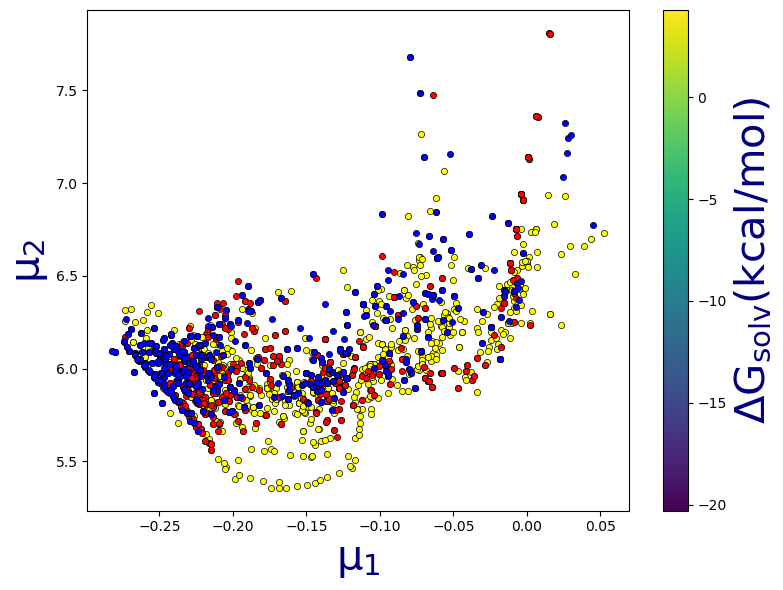

In [28]:
fig, ax = plt.subplots(figsize = [8, 6])
sns.scatterplot(x = reduced2[:,0], y = reduced2[:,1], c = "yellow", lw = 0.5, edgecolor = "black", cmap="viridis", s = 20)
sns.scatterplot(x = reduced1[:,0], y = reduced1[:,1], c = "red", lw = 0.5, edgecolor = "black", cmap="viridis", s = 20)
sns.scatterplot(x = reduced[:,0], y = reduced[:,1], c = "blue", lw = 0.5, edgecolor = "black", cmap="viridis", s = 20)
ax.set_xlabel(r"$\rm \mu_1$", color = "navy", fontsize = 30)
ax.set_ylabel(r"$\rm \mu_2$", color = "navy", fontsize = 30)
norm = plt.Normalize(props.min(), props.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
#ax.get_legend().remove()
#ax.figure.colorbar(sm)
cbar = fig.colorbar(sm, ax = ax, label = r"$\rm \Delta G_{solv}(kcal/mol)$")
cbar.set_label(r"$\rm \Delta G_{solv} (kcal/mol)$", fontsize = 30, color = "navy")
fig.tight_layout()
#plt.savefig("gcn_vae_full.png")

In [29]:
np.save('mnsol_gncvae.npy', reduced)
np.save('fsol_gncvae.npy', reduced1)
np.save('csol_gncvae.npy', reduced2)